In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools

from rdkit import Chem
from rdkit.Chem import AllChem

import utilsEvaluation

In [2]:
%matplotlib inline

In [3]:
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(colors)):    
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

#### 1. Load the data

In [4]:
rxnCls = pickle.load(file('data/rxnClasses.pickle'))

In [5]:
dataSetA = pd.read_csv('data/dataSetA.csv')

In [6]:
dataSetA.head()

,rxn_Class,patentID,rxn_Smiles,reactantSet
0,1,US08557776B2,CCOCC.CC(Cl)Cl.[CH3:10][N:9]([CH3:11])[c:8]1[c...,"set([2, 3])"
1,1,US08629160B2,CCOC(=O)C.CC#N.CO.[CH3:29][O:28][c:27]1[cH:26]...,"set([3, 4])"
2,1,US04381406,[CH3:5][CH2:6][N:7]([CH2:8][CH3:9])[CH2:10][CH...,"set([0, 3])"
3,1,US07091215B2,[BH-](OC(=O)C)(OC(=O)C)OC(=O)C.[CH3:1][CH2:2][...,"set([1, 4])"
4,1,US08765728B2,[BH4-].Cc1ccccc1.CO.[CH3:1][O:2][c:3]1[cH:4][c...,"set([3, 4])"


In [7]:
dataSetA.shape

(683, 4)

In [8]:
dataSetA['reactantSet'] = [eval(x) for x in dataSetA['reactantSet']]

In [9]:
dataSetB = pd.read_csv('data/dataSetB.csv')

In [10]:
dataSetB.head()

,rxn_Class,patentID,rxnSmiles_Mapping_NameRxn,reactantSet_NameRxn,NameRxn_Mapping_Complete,rxnSmiles_Mapping_IndigoTK,reactantSet_IndigoTK,IndigoTK_Mapping_Complete,rxnSmiles_IndigoAutoMapperKNIME,reactantSet_IndigoAutoMapperKNIME,IndigoAutoMapperKNIME_Mapping_Complete
0,6,US05849732,C.CCCCCC.CO.O=C(OCc1ccccc1)[NH:1][CH2:2][CH2:3...,"set([3, 4])",True,C(OC([NH:11][CH2:12][CH2:13][CH2:14][CH2:15][C...,"set([0, 2])",True,C.CCCCCC.CO.[CH3:10][O:11][C:12]([C@@H:14]([NH...,"set([3, 4])",True
1,2,US20120114765A1,O[C:1](=[O:2])[c:3]1[cH:4][c:5]([N+:6](=[O:7])...,"set([0, 1])",True,[Cl:1][c:2]1[cH:3][n:4][cH:5][c:6]([Cl:20])[c:...,"set([0, 1])",True,[NH2:1][c:2]1[c:11]2[c:6]([cH:7][n:8][cH:9][cH...,"set([0, 1])",True
2,1,US08003648B2,Cl.O=[CH:1][c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7...,"set([1, 3])",True,[CH2:1]([NH:3][CH2:4][CH3:5])[CH3:2].C([BH3-])...,"set([0, 3])",True,[CH3:1][CH2:2][NH:3][CH2:4][CH3:5].[CH3:6][c:7...,"set([0, 1])",True
3,1,US09045475B2,CC(=O)O[BH-](OC(C)=O)OC(C)=O.ClCCl.O=[C:1]([CH...,"set([2, 3])",True,[nH:1]1[c:5]2[n:6][cH:7][c:8]([O:10][c:11]3[cH...,"set([0, 3])",True,CC(O[BH-](OC(=O)C)OC(=O)C)=O.[CH3:14][C:15]1([...,"set([1, 3])",True
4,2,US08188098B2,CCN(C(C)C)C(C)C.ClCCl.Cl[C:1](=[O:2])[O:3][CH:...,"set([2, 5])",True,Cl[C:2]([O:4][CH:5]1[CH2:9][CH2:8][CH2:7][CH2:...,"set([0, 2])",True,CCN(C(C)C)C(C)C.[CH3:10][CH2:11][O:12][c:13]1[...,"set([1, 4])",True


In [11]:
dataSetB.shape

(50000, 11)

In [12]:
dataSetB['reactantSet_NameRxn'] = [eval(x) for x in dataSetB['reactantSet_NameRxn']]
dataSetB['reactantSet_IndigoTK'] = [eval(x) for x in dataSetB['reactantSet_IndigoTK']]
dataSetB['reactantSet_IndigoAutoMapperKNIME'] = [eval(x) for x in dataSetB['reactantSet_IndigoAutoMapperKNIME']]

#### Some statistics for data set A

In [13]:
stats=[]

for cls,smi,mr in zip(dataSetA['rxn_Class'],dataSetA['rxn_Smiles'],dataSetA['reactantSet']):
    rxn = AllChem.ReactionFromSmarts(str(smi), useSmiles=True)
    atoms=[]
    tmp=set()
    for r in range(rxn.GetNumReactantTemplates()):
        csmi = Chem.MolToSmiles(rxn.GetReactantTemplate(r))
        if csmi not in tmp:
            atoms.append(rxn.GetReactantTemplate(r).GetNumAtoms())
        tmp.add(csmi)
    atoms2=[]
    for r in mr:
        atoms2.append(rxn.GetReactantTemplate(r).GetNumAtoms()) 
    stats.append([cls,len(tmp),len(mr),atoms,atoms2])
stats = pd.DataFrame(stats,columns=['cls','numPossibleReactants','numTrueReactants','numAtomsAllPossibleReactants',\
                                    'numAtomsTrueReactants'])

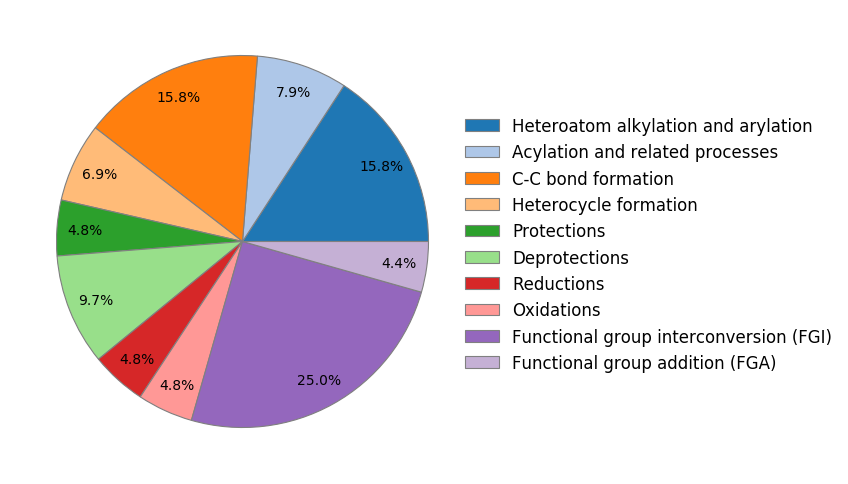

In [14]:
res = Counter(stats['cls'])
sortedData = sorted(res.items(), key=lambda x: int(x[0]),reverse=False)
superClasses = [x for x in np.array(sortedData)[:,0]]
values = [x[1] for x in sortedData]

fig, ax = plt.subplots(figsize=(6,6),dpi=600)
ax.pie(values,autopct='%1.1f%%',pctdistance=0.85,colors=colors,wedgeprops={'linewidth': 0.8,'edgecolor': 'gray'})
lgd=plt.legend([rxnCls[str(k)] for k in superClasses],bbox_to_anchor=(1.8, 0.8),frameon=False)
lgd.get_frame().set_facecolor('white')
lgd.get_frame().set_edgecolor('lightgray')
lgd.get_frame().set_linestyle(':')

_=plt.setp(plt.gca().get_legend().get_texts(), fontsize=12)

In [15]:
# fig.savefig("dataSetA_piePlot.png", dpi=600, format='png', bbox_inches='tight')

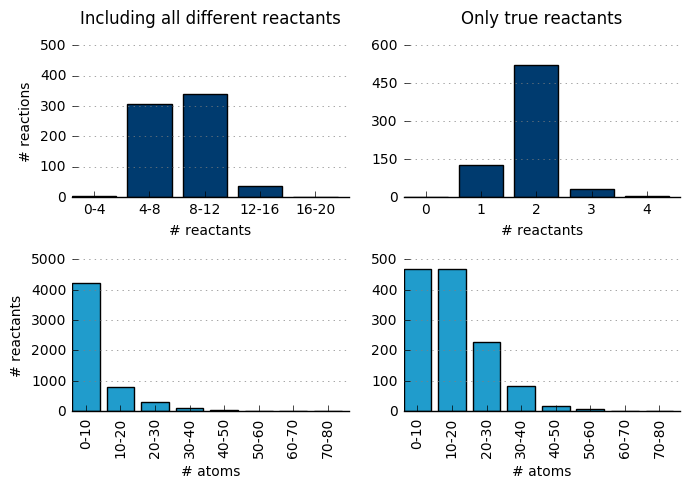

In [16]:
fig, ax = plt.subplots(2, 2, dpi=300, figsize=(7,5))

bins = np.arange(0,24,4)
hist = np.histogram(stats['numPossibleReactants'], bins=bins)[0]
x=np.arange(hist.shape[0])
b = ax[0,0].bar(x, hist, color='#003b6f')
width = b[0].get_width()*0.5
ax[0,0].set_xticks(x + width)
ax[0,0].set_xticklabels([str(bins[i])+'-'+str(bins[i+1]) for i in range(len(bins)-1)])#,rotation='vertical')
ax[0,0].set_yticks(np.arange(0,600,100))

bins = np.arange(0,6,1)
hist = np.histogram(stats['numTrueReactants'], bins=bins)[0]
x=np.arange(hist.shape[0])
b = ax[0,1].bar(x, hist, color='#003b6f')
width = b[0].get_width()*0.5
ax[0,1].set_xticks(x + width)
ax[0,1].set_xticklabels([str(bins[i]) for i in range(len(bins))])#,rotation='vertical')
ax[0,1].set_yticks(np.arange(0,750,150))

numAtms1 = list(itertools.chain(*stats['numAtomsAllPossibleReactants']))
numAtms2 = list(itertools.chain(*stats['numAtomsTrueReactants']))

bins = np.arange(0,90,10)
hist = np.histogram(numAtms1, bins=bins)[0]
x=np.arange(hist.shape[0])
b = ax[1,0].bar(x, hist, color='#209ccc')
width = b[0].get_width()*0.5
ax[1,0].set_xticks(x + width)
ax[1,0].set_xticklabels([str(bins[i])+'-'+str(bins[i+1]) for i in range(len(bins)-1)],rotation='vertical')
ax[1,0].set_yticks(np.arange(0,6000,1000))

bins = np.arange(0,90,10)
hist = np.histogram(numAtms2, bins=bins)[0]
x=np.arange(hist.shape[0])
b = ax[1,1].bar(x, hist, color='#209ccc')
width = b[0].get_width()*0.5
ax[1,1].set_xticks(x + width)
ax[1,1].set_xticklabels([str(bins[i])+'-'+str(bins[i+1]) for i in range(len(bins)-1)],rotation='vertical')
ax[1,1].set_yticks(np.arange(0,600,100))

ttl1 = ax[0,0].set_title('Including all different reactants')
ttl2 = ax[0,1].set_title('Only true reactants')
ttl1.set_position([.5, 1.1])
ttl2.set_position([.5, 1.1])

ax[0,0].set_ylabel('# reactions')
ax[1,0].set_ylabel('# reactants')

ax[0,0].set_xlabel('# reactants')
ax[0,1].set_xlabel('# reactants')
ax[1,0].set_xlabel('# atoms')
ax[1,1].set_xlabel('# atoms')

utilsEvaluation.setPlotProperties(ax[0,0])
utilsEvaluation.setPlotProperties(ax[0,1])
utilsEvaluation.setPlotProperties(ax[1,0])
utilsEvaluation.setPlotProperties(ax[1,1])
plt.tight_layout()

In [17]:
# fig.savefig("dataSetA_reactantAtomDistribution.png", dpi=600, format='png', bbox_inches='tight')

#### Some statistics for data set B

In [18]:
stats=[]

for cls,smi,mr in zip(dataSetB['rxn_Class'],dataSetB['rxnSmiles_Mapping_NameRxn'],dataSetB['reactantSet_NameRxn']):
    rxn = AllChem.ReactionFromSmarts(str(smi), useSmiles=True)
    atoms=[]
    tmp=set()
    for r in range(rxn.GetNumReactantTemplates()):
        csmi = Chem.MolToSmiles(rxn.GetReactantTemplate(r))
        if csmi not in tmp:
            atoms.append(rxn.GetReactantTemplate(r).GetNumAtoms())
        tmp.add(csmi)
    atoms2=[]
    for r in mr:
        atoms2.append(rxn.GetReactantTemplate(r).GetNumAtoms()) 
    stats.append([cls,len(tmp),len(mr),atoms,atoms2])
stats = pd.DataFrame(stats,columns=['cls','numPossibleReactants','numTrueReactants','numAtomsAllPossibleReactants',\
                                    'numAtomsTrueReactants'])

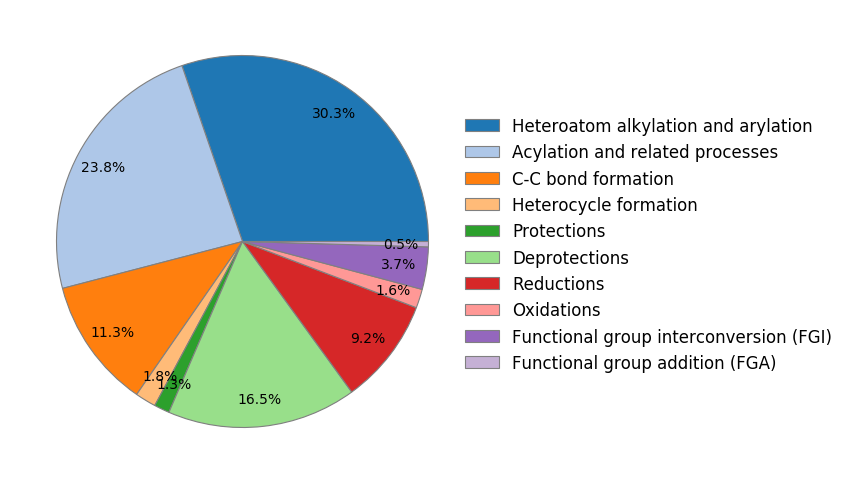

In [19]:
res = Counter(stats['cls'])
sortedData = sorted(res.items(), key=lambda x: int(x[0]),reverse=False)
superClasses = [x for x in np.array(sortedData)[:,0]]
values = [x[1] for x in sortedData]

fig, ax = plt.subplots(figsize=(6,6),dpi=600)
ax.pie(values,autopct='%1.1f%%',pctdistance=0.85,colors=colors,wedgeprops={'linewidth': 0.8,'edgecolor': 'gray'})
lgd=plt.legend([rxnCls[str(k)] for k in superClasses],bbox_to_anchor=(1.8, 0.8),frameon=False)
lgd.get_frame().set_facecolor('white')
lgd.get_frame().set_edgecolor('lightgray')
lgd.get_frame().set_linestyle(':')

_=plt.setp(plt.gca().get_legend().get_texts(), fontsize=12)

In [20]:
# fig.savefig("dataSetB_piePlot.png", dpi=600, format='png', bbox_inches='tight')

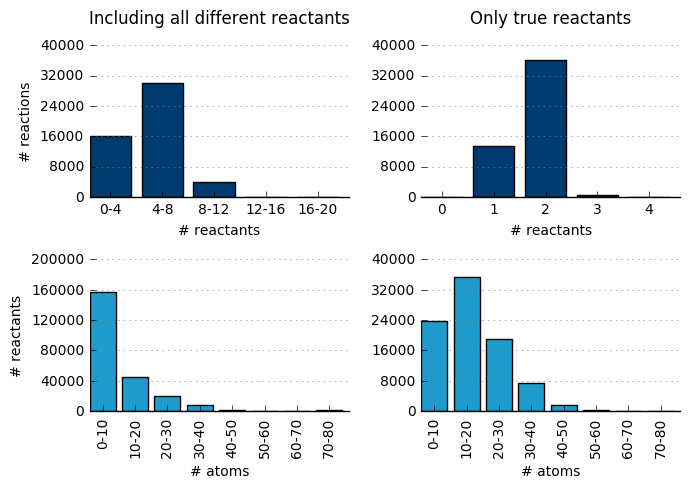

In [21]:
fig, ax = plt.subplots(2, 2, dpi=300, figsize=(7,5))

bins = np.arange(0,24,4)
hist = np.histogram(stats['numPossibleReactants'], bins=bins)[0]
x=np.arange(hist.shape[0])
b = ax[0,0].bar(x, hist, color='#003b6f')
width = b[0].get_width()*0.5
ax[0,0].set_xticks(x + width)
ax[0,0].set_xticklabels([str(bins[i])+'-'+str(bins[i+1]) for i in range(len(bins)-1)])#,rotation='vertical')
ax[0,0].set_yticks(np.arange(0,48000,8000))

bins = np.arange(0,6,1)
hist = np.histogram(stats['numTrueReactants'], bins=bins)[0]
x=np.arange(hist.shape[0])
b = ax[0,1].bar(x, hist, color='#003b6f')
width = b[0].get_width()*0.5
ax[0,1].set_xticks(x + width)
ax[0,1].set_xticklabels([str(bins[i]) for i in range(len(bins))])#,rotation='vertical')
ax[0,1].set_yticks(np.arange(0,48000,8000))

numAtms1 = list(itertools.chain(*stats['numAtomsAllPossibleReactants']))
numAtms2 = list(itertools.chain(*stats['numAtomsTrueReactants']))

bins = np.arange(0,90,10)
hist = np.histogram(numAtms1, bins=bins)[0]
x=np.arange(hist.shape[0])
b = ax[1,0].bar(x, hist, color='#209ccc')
width = b[0].get_width()*0.5
ax[1,0].set_xticks(x + width)
ax[1,0].set_xticklabels([str(bins[i])+'-'+str(bins[i+1]) for i in range(len(bins)-1)],rotation='vertical')
ax[1,0].set_yticks(np.arange(0,240000,40000))

bins = np.arange(0,90,10)
hist = np.histogram(numAtms2, bins=bins)[0]
x=np.arange(hist.shape[0])
b = ax[1,1].bar(x, hist, color='#209ccc')
width = b[0].get_width()*0.5
ax[1,1].set_xticks(x + width)
ax[1,1].set_xticklabels([str(bins[i])+'-'+str(bins[i+1]) for i in range(len(bins)-1)],rotation='vertical')
ax[1,1].set_yticks(np.arange(0,48000,8000))

ttl1 = ax[0,0].set_title('Including all different reactants')
ttl2 = ax[0,1].set_title('Only true reactants')
ttl1.set_position([.5, 1.1])
ttl2.set_position([.5, 1.1])

ax[0,0].set_ylabel('# reactions')
ax[1,0].set_ylabel('# reactants')

ax[0,0].set_xlabel('# reactants')
ax[0,1].set_xlabel('# reactants')
ax[1,0].set_xlabel('# atoms')
ax[1,1].set_xlabel('# atoms')

utilsEvaluation.setPlotProperties(ax[0,0])
utilsEvaluation.setPlotProperties(ax[0,1])
utilsEvaluation.setPlotProperties(ax[1,0])
utilsEvaluation.setPlotProperties(ax[1,1])
plt.tight_layout()

In [22]:
# fig.savefig("dataSetB_reactantAtomDistribution.png", dpi=600, format='png', bbox_inches='tight')